# Dataset: FER2013

## Import Libraries

In [2]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import random
import os
import urllib.request
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras import layers
from keras import Model
import keras.utils as image
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import callbacks
from keras.layers import Input

## Data Collection

In [4]:
for dirname, _, filenames in os.walk("FER2013 - Images"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

FER2013 - Images\test\angry\PrivateTest_10131363.jpg
FER2013 - Images\test\angry\PrivateTest_10304478.jpg
FER2013 - Images\test\angry\PrivateTest_1054527.jpg
FER2013 - Images\test\angry\PrivateTest_10590091.jpg
FER2013 - Images\test\angry\PrivateTest_1109992.jpg
FER2013 - Images\test\angry\PrivateTest_11296953.jpg
FER2013 - Images\test\angry\PrivateTest_12000629.jpg
FER2013 - Images\test\angry\PrivateTest_12008383.jpg
FER2013 - Images\test\angry\PrivateTest_12191716.jpg
FER2013 - Images\test\angry\PrivateTest_1221822.jpg
FER2013 - Images\test\angry\PrivateTest_12403575.jpg
FER2013 - Images\test\angry\PrivateTest_12766285.jpg
FER2013 - Images\test\angry\PrivateTest_12846357.jpg
FER2013 - Images\test\angry\PrivateTest_1290484.jpg
FER2013 - Images\test\angry\PrivateTest_12912780.jpg
FER2013 - Images\test\angry\PrivateTest_13164119.jpg
FER2013 - Images\test\angry\PrivateTest_13278552.jpg
FER2013 - Images\test\angry\PrivateTest_13463625.jpg
FER2013 - Images\test\angry\PrivateTest_13541561.j

In [5]:
train_dir = 'FER2013 - Images/train'
test_dir = 'FER2013 - Images/test'

In [6]:
img_size1 = 96
bth_size1 = 64

In [7]:
train_gen = ImageDataGenerator(rotation_range=20,
                              rescale=1./255,
                              shear_range=0.1,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              width_shift_range=0.1,
                              height_shift_range=0.1)

training_data = train_gen.flow_from_directory(train_dir,
                                             target_size=(img_size1,img_size1),
                                             batch_size=bth_size1,
                                             color_mode = "rgb",
                                             class_mode = "categorical")

Found 28709 images belonging to 7 classes.


In [8]:
valid_gen = ImageDataGenerator(rescale=1./255)

valid_data = valid_gen.flow_from_directory(test_dir,
                                          target_size=(img_size1,img_size1),
                                          batch_size=bth_size1,
                                          color_mode='rgb',
                                          class_mode='categorical')

Found 7178 images belonging to 7 classes.


## Model Building

In [11]:
pre_trained_model = InceptionV3(input_shape = (img_size1,img_size1,3),
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 47, 47, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 47, 47, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 47, 47, 32)   0           ['batch_normalization[

In [12]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4, 4, 768)


In [13]:
#EVALUATION

import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [14]:
#EVALUATION

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [15]:
base_learning_rate = 0.0001

In [16]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)                  
x = layers.Dense  (7, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = Adam(learning_rate=base_learning_rate), 
              loss = 'categorical_crossentropy', 
              metrics = METRICS)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 47, 47, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 47, 47, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 47, 47, 32)   0           ['batch_normalization[0][0]']

In [18]:
# Create Callback Checkpoint
filepath="Best1.hdf5"
Checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min')

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=20,
                                                  min_lr=0.000005,
                                                  verbose=1)

callbacks_list1 = [Checkpoint, Early_Stopping, Reducing_LR]

In [19]:
initial_epoch = 20

In [20]:
history = model.fit(
            training_data,
            epochs = initial_epoch,validation_data=valid_data,callbacks=callbacks_list1)

Epoch 1/20
449/449 [==============================] - 82s 167ms/step - loss: 1.6829 - accuracy: 0.8612 - precision: 0.5734 - recall: 0.1114 - auc: 0.7345 - f1_score: 0.1830 - val_loss: 1.4251 - val_accuracy: 0.8772 - val_precision: 0.7403 - val_recall: 0.2161 - val_auc: 0.8196 - val_f1_score: 0.3331 - lr: 1.0000e-04
Epoch 2/20
449/449 [==============================] - 62s 139ms/step - loss: 1.5237 - accuracy: 0.8693 - precision: 0.6609 - recall: 0.1749 - auc: 0.7901 - f1_score: 0.2742 - val_loss: 1.3553 - val_accuracy: 0.8801 - val_precision: 0.7679 - val_recall: 0.2304 - val_auc: 0.8409 - val_f1_score: 0.3528 - lr: 1.0000e-04
Epoch 3/20
449/449 [==============================] - 61s 135ms/step - loss: 1.4705 - accuracy: 0.8720 - precision: 0.6730 - recall: 0.2022 - auc: 0.8080 - f1_score: 0.3087 - val_loss: 1.3193 - val_accuracy: 0.8823 - val_precision: 0.7826 - val_recall: 0.2437 - val_auc: 0.8514 - val_f1_score: 0.3680 - lr: 1.0000e-04
Epoch 4/20
449/449 [==========================

## Quantitative Evaluation

In [21]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']

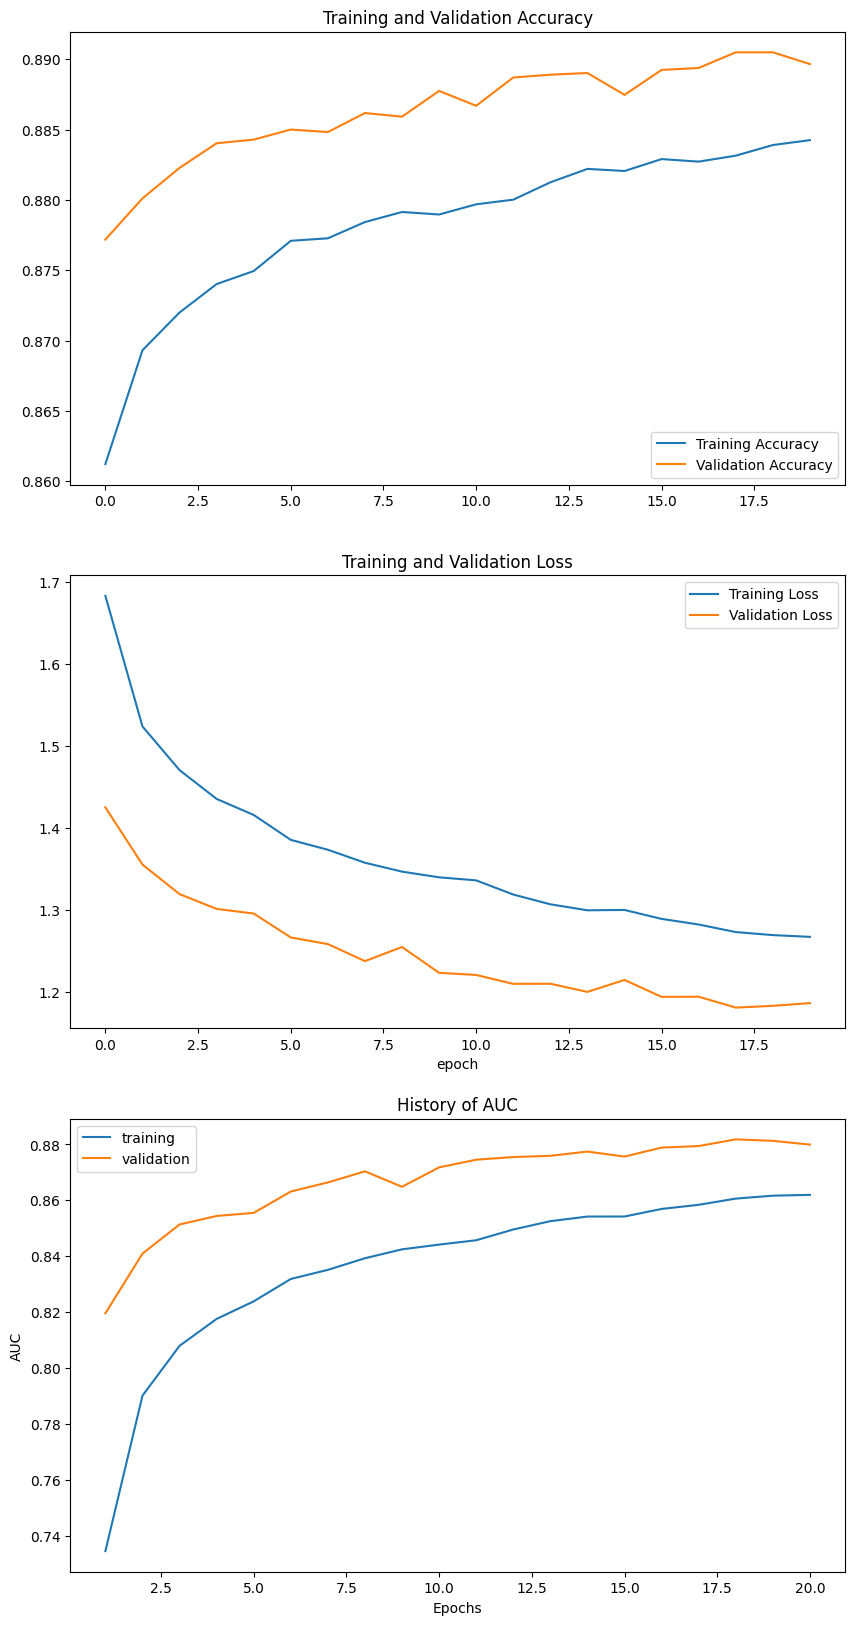

In [22]:
epochs_range = range(len(train_acc))

plt.figure(figsize=(10, 20))
plt.subplot(3, 1, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 1, 3)
plt.plot(range(1, len(train_auc) + 1), train_auc)
plt.plot(range(1, len(val_auc) + 1), val_auc)
plt.title('History of AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['training', 'validation'])
plt.show()

In [23]:
#EVALUATION

print('Train Accuracy: ', round(history.history['accuracy'][-1],2))
print('Train Loss: ', round(history.history['loss'][-1],2))
print('Train Precision: ', round(history.history['precision'][-1],2))
print('Train Recall: ', round(history.history['recall'][-1],2))
print('Train F1-Score: ', round(history.history['f1_score'][-1],2))


Train Accuracy:  0.88
Train Loss:  1.27


In [24]:
#EVALUATION

print('Test Accuracy: ', round(history.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history.history['val_loss'][-1],2))
print('Test Precision: ', round(history.history['val_precision'][-1],2))
print('Test Recall: ', round(history.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history.history['val_f1_score'][-1],2))

Train Precision:  0.72
Train Recall:  0.31
Train F1-Score:  0.43


## Fine Tuning

In [25]:
len(model.layers)

235

In [26]:
NB_IV3_LAYERS_TO_FREEZE = 172

In [27]:
for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
    layer.trainable = False
for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
    layer.trainable = True
model.compile(optimizer = Adam(learning_rate=base_learning_rate/10), 
              loss = 'categorical_crossentropy', 
              metrics = METRICS)

In [28]:
# Create Callback Checkpoint
filepath="Best1.hdf5"
Checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min')

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=20,
                                                  min_lr=0.000005,
                                                  verbose=1)

callbacks_list2 = [Checkpoint, Early_Stopping, Reducing_LR]

In [29]:
fine_tune_epochs = 20
total_epochs =  initial_epoch + fine_tune_epochs

history_fine = model.fit(training_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_data,
                         callbacks = callbacks_list2)

Epoch 20/40
449/449 [==============================] - 66s 137ms/step - loss: 1.5036 - accuracy: 0.8734 - precision: 0.7334 - recall: 0.1787 - auc: 0.8169 - f1_score: 0.2286 - val_loss: 1.3444 - val_accuracy: 0.8797 - val_precision: 0.7710 - val_recall: 0.2247 - val_auc: 0.8457 - val_f1_score: 0.3432 - lr: 1.0000e-05
Epoch 21/40
449/449 [==============================] - 63s 141ms/step - loss: 1.3919 - accuracy: 0.8760 - precision: 0.7195 - recall: 0.2159 - auc: 0.8306 - f1_score: 0.3300 - val_loss: 1.2858 - val_accuracy: 0.8830 - val_precision: 0.7684 - val_recall: 0.2593 - val_auc: 0.8589 - val_f1_score: 0.3835 - lr: 1.0000e-05
Epoch 22/40
449/449 [==============================] - 61s 135ms/step - loss: 1.3426 - accuracy: 0.8790 - precision: 0.7214 - recall: 0.2491 - auc: 0.8433 - f1_score: 0.3685 - val_loss: 1.2513 - val_accuracy: 0.8853 - val_precision: 0.7655 - val_recall: 0.2838 - val_auc: 0.8665 - val_f1_score: 0.4102 - lr: 1.0000e-05
Epoch 23/40
449/449 [======================

## Quantitative Evaluation

In [30]:
train_acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
train_loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
train_auc += history_fine.history['auc']
val_auc += history_fine.history['val_auc']

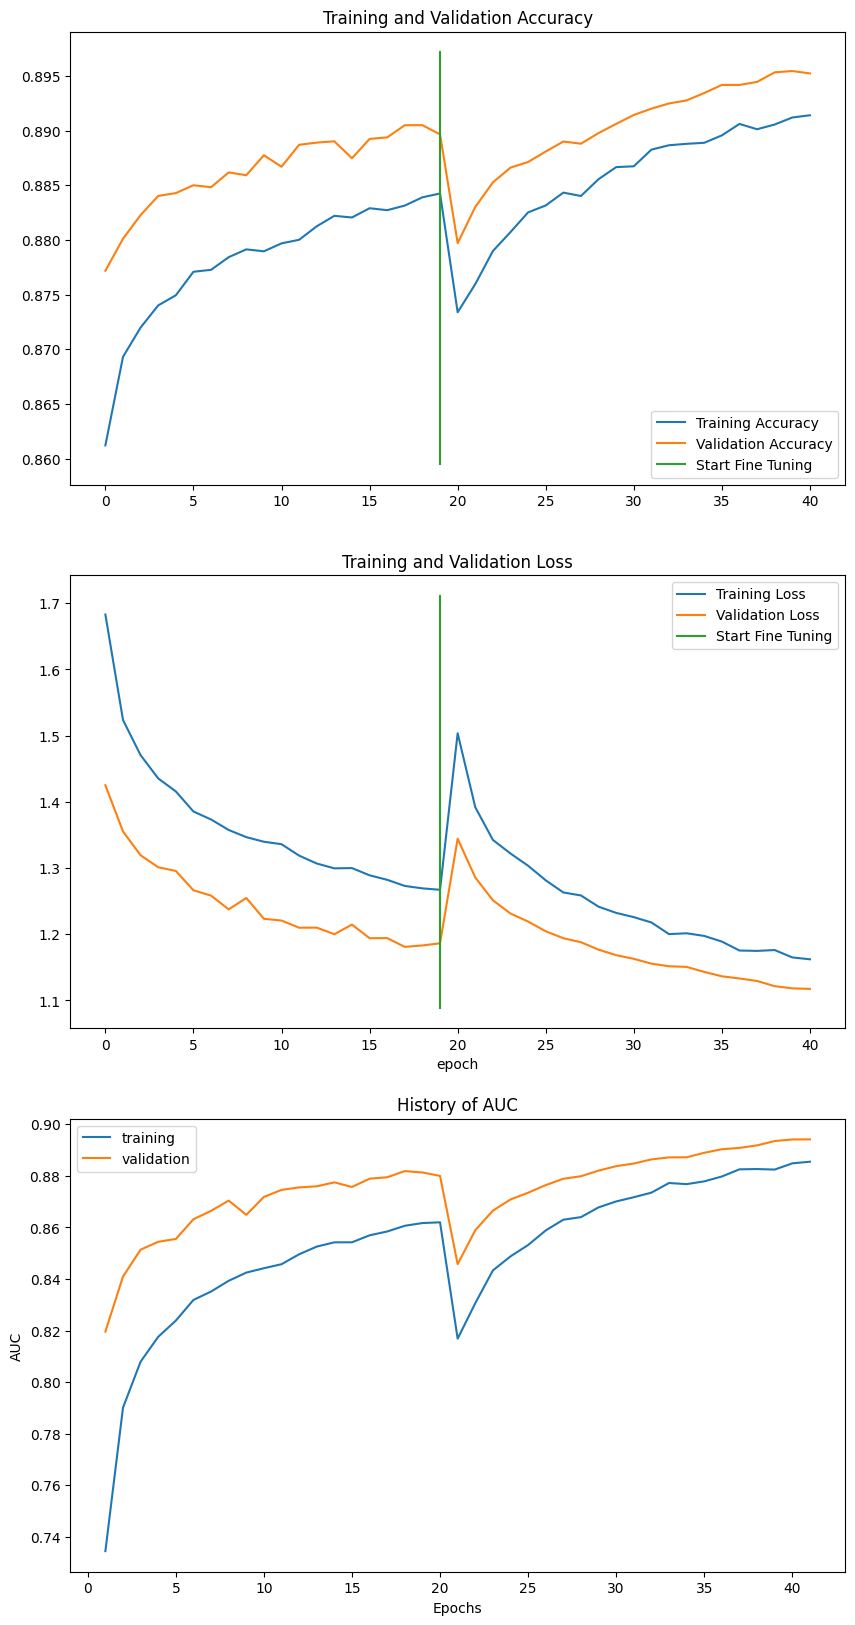

In [31]:
epochs_range = range(len(train_acc))

plt.figure(figsize=(10, 20))
plt.subplot(3, 1, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot([initial_epoch-1,initial_epoch-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.plot([initial_epoch-1,initial_epoch-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 1, 3)
plt.plot(range(1, len(train_auc) + 1), train_auc)
plt.plot(range(1, len(val_auc) + 1), val_auc)
plt.title('History of AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['training', 'validation'])
plt.show()
    

In [32]:
#EVALUATION

print('Train Accuracy: ', round(history_fine.history['accuracy'][-1],2))
print('Train Loss: ', round(history_fine.history['loss'][-1],2))
print('Train Precision: ', round(history_fine.history['precision'][-1],2))
print('Train Recall: ', round(history_fine.history['recall'][-1],2))
print('Train F1-Score: ', round(history_fine.history['f1_score'][-1],2))

Train Accuracy:  0.89
Train Loss:  1.16
Train Precision:  0.74
Train Recall:  0.37
Train F1-Score:  0.49


In [33]:
#EVALUATION

print('Test Accuracy: ', round(history_fine.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history_fine.history['val_loss'][-1],2))
print('Test Precision: ', round(history_fine.history['val_precision'][-1],2))
print('Test Recall: ', round(history_fine.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history_fine.history['val_f1_score'][-1],2))

Test Accuracy:  0.9
Test Loss:  1.12
Test Precision:  0.75
Test Recall:  0.4
Test F1-Score:  0.52


In [67]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap='viridis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [68]:
y_true = valid_data.classes
y_hat =  model.predict(valid_data)
y_hat = tf.argmax(y_hat, axis = 1).numpy()
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

113/113 [==============================] - 5s 40ms/step


Confusion matrix, without normalization
[[130   6  70 268 196 154 134]
 [ 14   0   7  29  25  19  17]
 [139   2  70 291 232 154 136]
 [249   5 133 514 355 257 261]
 [159   4  98 363 262 180 167]
 [175   4  87 348 261 195 177]
 [115   2  52 229 195 130 108]]


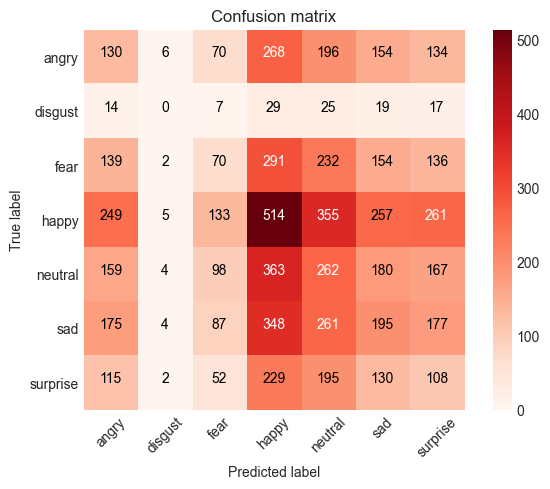

In [69]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_true, y_pred = y_hat)
plot_confusion_matrix(cm, classes, cmap = 'Reds')
plt.savefig('confmat.png')

## Qualitative Evaluation

1/1 [==============================] - 0s 29ms/step


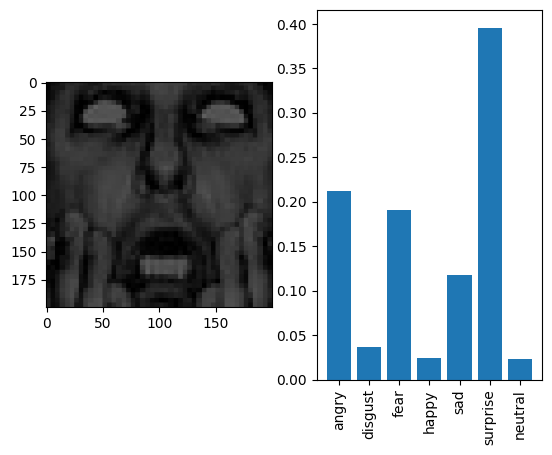

Expression Prediction: surprise
1/1 [==============================] - 0s 32ms/step


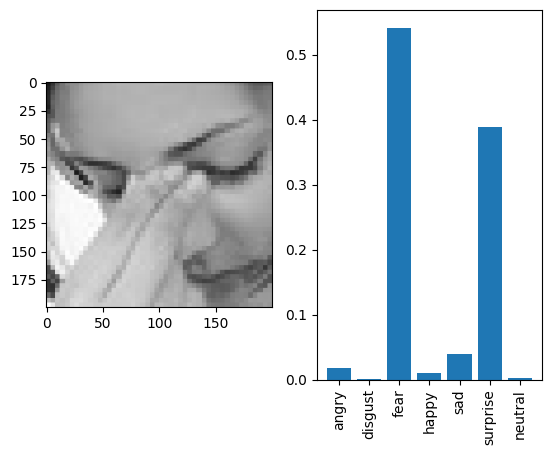

Expression Prediction: fear
1/1 [==============================] - 0s 32ms/step


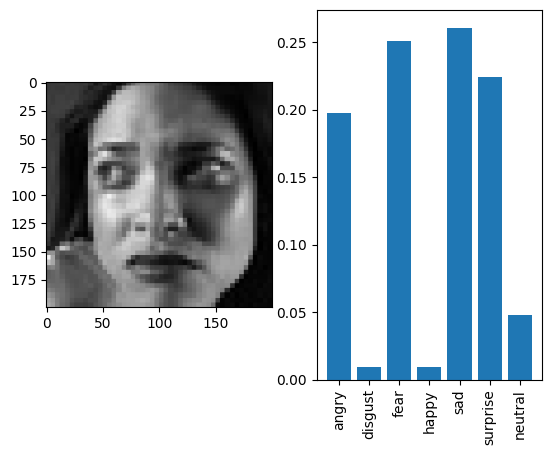

Expression Prediction: sad
1/1 [==============================] - 0s 32ms/step


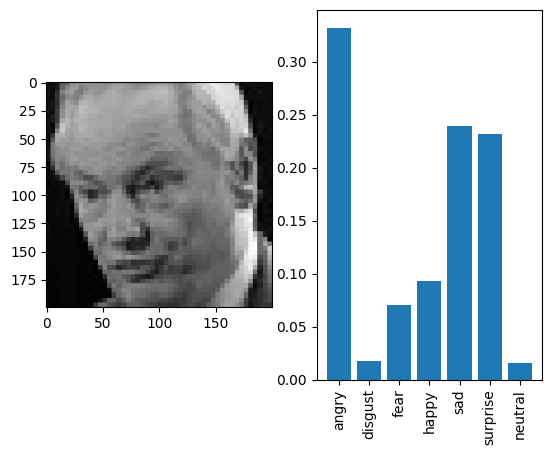

Expression Prediction: angry
1/1 [==============================] - 0s 32ms/step


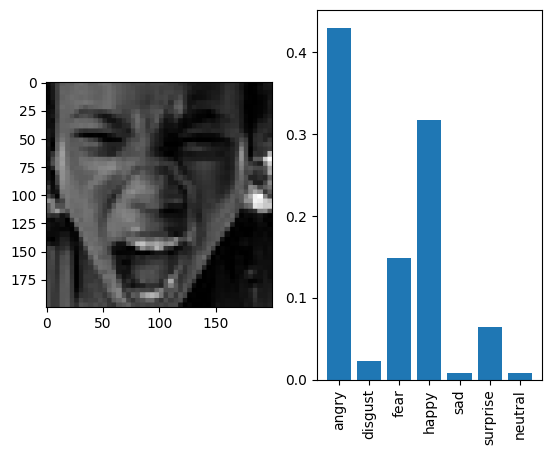

Expression Prediction: angry
1/1 [==============================] - 0s 31ms/step


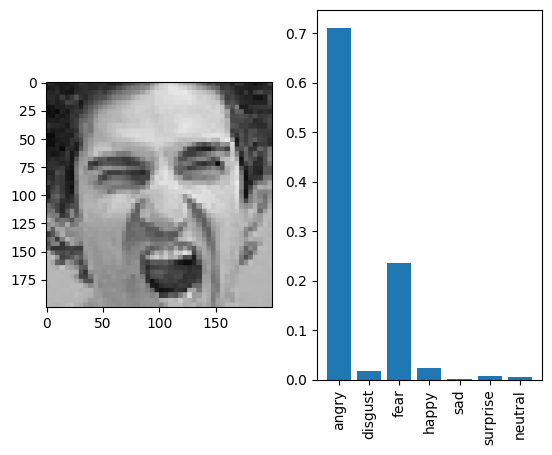

Expression Prediction: angry
1/1 [==============================] - 0s 29ms/step


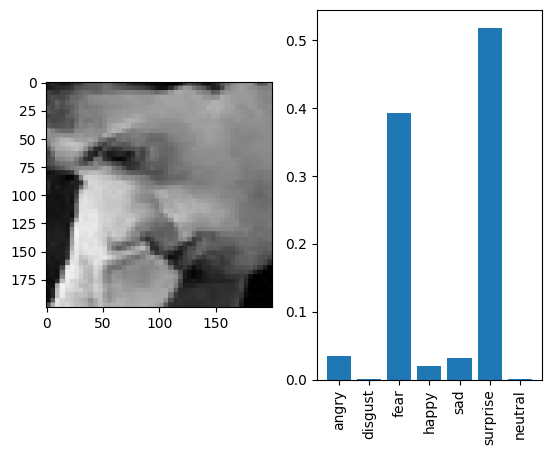

Expression Prediction: surprise
1/1 [==============================] - 0s 31ms/step


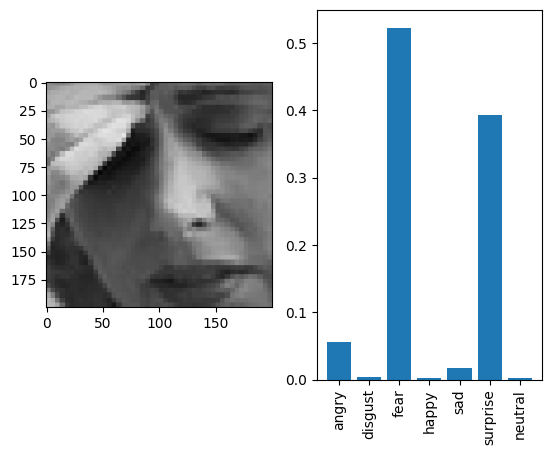

Expression Prediction: fear
1/1 [==============================] - 0s 32ms/step


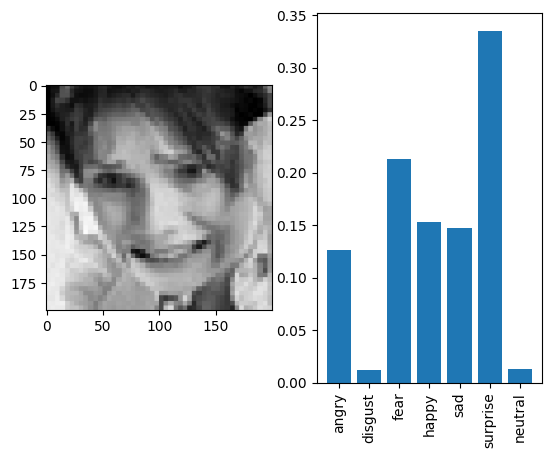

Expression Prediction: surprise
1/1 [==============================] - 0s 34ms/step


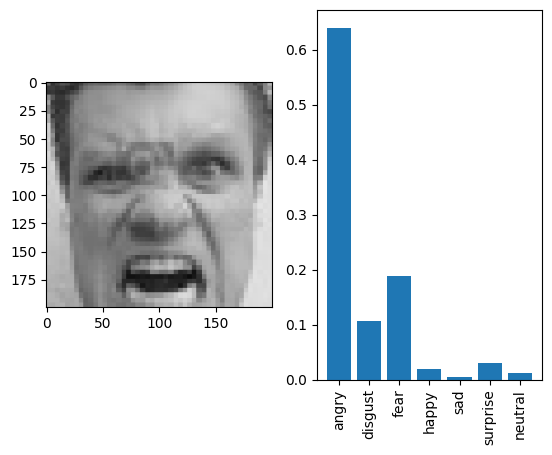

Expression Prediction: angry


In [41]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
for i in range(0, 10):
    randimg = random.choice(os.listdir("FER2013 - Images/test/fear/"))
    randimgpath = "FER2013 - Images/test/fear/" + randimg
    img = image.load_img(randimgpath, target_size = (96, 96))
    show_img = image.load_img(randimgpath, target_size = (200, 200))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    x /= 255

    custom = model.predict(x)

    x = np.array(x, 'float32')
    x = x.reshape([96, 96, 3]);

    plt.gray()
    plt.subplot(1,2,1)
    plt.imshow(show_img)
    
    plt.subplot(1,2,2)
    plt.bar(objects,custom[0])
    plt.xticks(rotation=90)
    
    plt.show()

    a = custom[0]
    m = a[0]
    for i in range(0,len(a)):
        if a[i] >= m:
            m = a[i]
            ind = i

    print('Expression Prediction:',objects[ind])